### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [75]:
import sys
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/99ae2a3dae648428edbfc41fd10ed688e5365161/week07_%5Brecap%5D_rnn/names -O names

In [76]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [77]:
import os
start_token = " "

with open("names") as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + line for line in lines]

In [78]:
print ('n samples = ',len(lines))
for x in lines[::1000]:
    print (x)
    


n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


(array([1.900e+01, 2.720e+02, 0.000e+00, 9.260e+02, 0.000e+00, 1.878e+03,
        0.000e+00, 2.049e+03, 0.000e+00, 1.447e+03, 0.000e+00, 8.460e+02,
        0.000e+00, 3.510e+02, 0.000e+00, 1.160e+02, 0.000e+00, 2.400e+01,
        0.000e+00, 1.000e+01, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00]),
 array([ 3.  ,  3.52,  4.04,  4.56,  5.08,  5.6 ,  6.12,  6.64,  7.16,
         7.68,  8.2 ,  8.72,  9.24,  9.76, 10.28, 10.8 , 11.32, 11.84,
        12.36, 12.88, 13.4 , 13.92, 14.44, 14.96, 15.48, 16.  ]),
 <BarContainer object of 25 artists>)

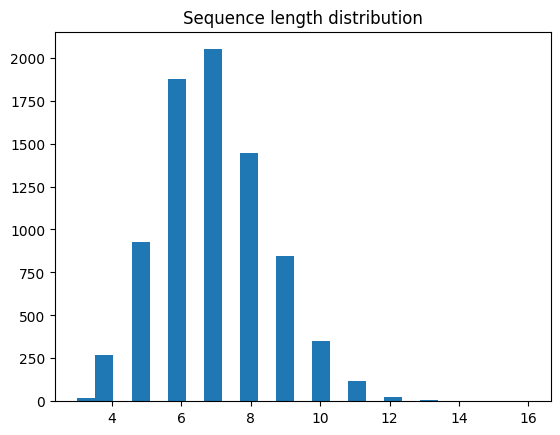

In [79]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25)

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [80]:
#all unique characters go here
tokens = set(''.join(lines))

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  55


### Convert characters to integers

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [81]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [82]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [83]:
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [84]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[29 36 43  9 32  9 13 27 29]
 [29 50 27 44 22 21 29 29 29]
 [29 12 22 16 19 19 16 13 29]
 [29 50 16 44 24  9 37 37 13]]


# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="https://github.com/yandexdataschool/Practical_RL/blob/master/week07_%5Brecap%5D_rnn/rnn.png?raw=1" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [85]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        h_next = self.rnn_update(torch.cat([x_emb, h_prev], dim=-1))
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units)

In [86]:
char_rnn = CharRNNCell()
char_rnn

CharRNNCell(
  (embedding): Embedding(55, 16)
  (rnn_update): Linear(in_features=80, out_features=64, bias=True)
  (rnn_to_logits): Linear(in_features=64, out_features=55, bias=True)
)

### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [87]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [88]:
batch_ix = to_matrix(lines[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [89]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

loss = -logp_next.mean()

In [90]:
loss.backward()

In [91]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [92]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

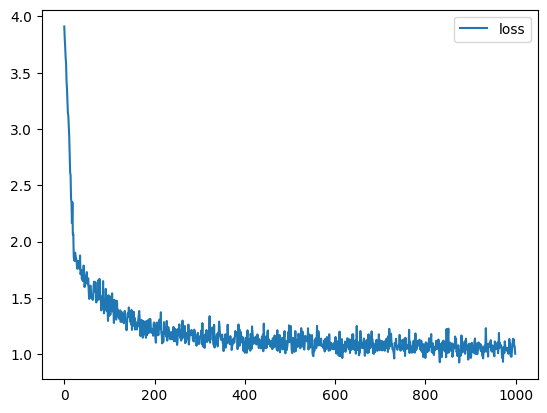

In [93]:

for i in range(1000):
    batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
    
    loss = -logp_next.mean()
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [94]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [95]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Shann          
 Goa            
 Kiseye         
 Segsed         
 Shipcorte      
 Gandalony      
 Juonsaane n    
 Billa          
 Sustisa        
 Pipioll        


In [96]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' Trump'))

 Trumphhan      
 Trumpo         
 Trumporth      
 Trumpyn        
 Trumpa         
 Trumpa         
 Trumpy         
 Trumpie        
 Trumpad        
 Trumpe         
 Trumporli      
 Trumper        
 Trumpemice     
 Trumpene       
 Trumpba        
 Trumpert       
 Trumpise       
 Trumpy         
 Trumpainn      
 Trumpoldel     
 Trumpie        
 Trumpek        
 Trumpe         
 Trumpy         
 Trumptra       
 Trumpor        
 Trumpear       
 Trumphexne     
 Trumpis        
 Trumpia        
 Trumpay        
 Trumpy         
 Trumper        
 Trumpir        
 Trumpoamy      
 TrumpVey       
 Trumpa         
 Trumpor        
 Trumpia        
 Trump          
 Trumpk         
 Trumpy         
 Trumpi         
 Trumpey        
 Trumpi         
 Trumpee        
 Trumpi         
 Trumpim        
 Trumpa         
 Trumplarain    


### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__

### More seriously

What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion. 

As you might have guessed, torch has a solution for this. To be more specific, there are two options:
* `nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - implements the whole rnn_loop for you.

There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

In [97]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()

In [98]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = model(batch_ix)

# compute loss. This time we use nll_loss with some duct tape
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

Here's another example

In [99]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharLSTMCell(nn.Module):
    """
    Implements something like CharRNNCell, but with LSTM
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        
        return (next_h, next_c), F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return torch.zeros(batch_size, self.num_units), torch.zeros(batch_size, self.num_units)
    
char_lstm = CharLSTMCell()

In [100]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_lstm, batch_ix)

# compute loss. This time we use nll_loss with some duct tape
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

__Bonus quest: __ implement a model that uses 2 LSTM layers (the second lstm uses the first as input) and train it on your data.

In [101]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super().__init__()

        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm1 = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.lstm2 = nn.LSTM(rnn_num_units, rnn_num_units, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        h_seq, _ = self.lstm1(self.emb(x))
        h_seq, _ = self.lstm2(h_seq)
        next_logits = self.rnn_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

    def generate_sample(self, tokens, token_to_id, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
        x_sequence = [token_to_id[token] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        logp_seq = self(x_sequence)
        
        madeUp_word = seed_phrase
        
        for _ in range(max_length - len(seed_phrase)):
            p_next = F.softmax(logp_seq[:, -1] / temperature, dim=-1).data.numpy()[0]
            next_ix = np.random.choice(num_tokens,p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
            logp_seq = self(x_sequence)
            madeUp_word += tokens[next_ix.data.numpy()[0,0]]            

        return madeUp_word
    
model = CharLSTMLoop()

In [102]:
batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = model(batch_ix)

loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

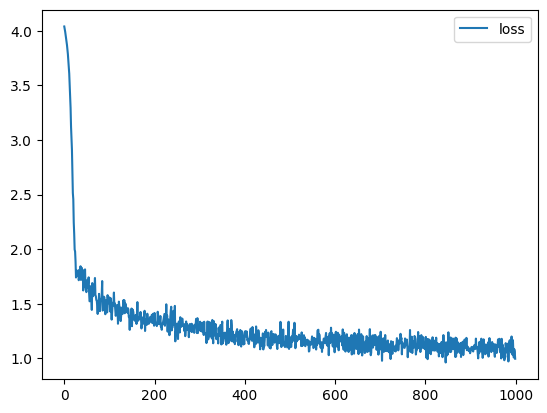

In [103]:
model = CharLSTMLoop()
opt = torch.optim.Adam(model.parameters())

history = []
for i in range(1000):
    batch_ix = to_matrix(
        sample(lines, 32), pad=token_to_id[" "], max_len=MAX_LENGTH
    )
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    logp_seq = model(batch_ix)
    loss = F.nll_loss(
        logp_seq[:, :-1].contiguous().view(-1, num_tokens),
        batch_ix[:, 1:].contiguous().view(-1),
    )
    loss.backward()
    opt.step()
    opt.zero_grad()
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()
assert np.mean(history[:10]) > np.mean(history[-10:]), "Model didn't converge."

In [104]:
for _ in range(10):
    print(model.generate_sample(tokens, token_to_id, seed_phrase=" Poke"))

 Pokene         
 Pokesih        
 Poke           
 Poked          
 Pokelon        
 Poke           
 Poken          
 Poke           
 Pokee          
 Pokeand        


In [ ]:
start_token = " "
with open("mtg_card_names.txt") as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + line for line in lines]

MAX_LENGTH = max(map(len, lines))

tokens = list(set(''.join(lines)))

num_tokens = len(tokens)

token_to_id = {token: idx for idx, token in enumerate(tokens)}

MAX_LENGTH, num_tokens

(169, 78)

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
print('\n'.join(lines[::5000]))
print(to_matrix(lines[::5000]))

 [1G] Instant: Moonmist
 [UB] Creature, Spirit: Dimir Infiltrator
 [None] Plane, Ulgrotha: The Dark Barony
 [None] Legendary Creature, Eldrazi Angel: Brisela, Voice of Nightmares
[[52 11 47 20 50 52 28 57 29 66 65 57 66 62 52 53 15 15 57 24 69 29 66 29
  29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
  29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29]
 [52 11 43  3 50 52 34  5  2 65 66 41  5  2 37 52 25 35 69  5 69 66 62 52
  16 69 24 69  5 52 28 57 44 69 71 66  5 65 66 15  5 29 29 29 29 29 29 29
  29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29]
 [52 11 74 15 57  2 50 52  1 71 65 57  2 37 52 43 71  9  5 15 66 32 65 62
  52 42 32  2 52 16 65  5 40 52  3 65  5 15 57  6 29 29 29 29 29 29 29 29
  29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29]
 [52 11 74 15 57  2 50 52 27  2  9  2 57 17 65  5  6 52 34  5  2 65 66 41
   5  2 37 52 19 71 17  5 65 55 69 52 10 57  9  2 71 62 52  3  5 69 29  2
  71 65 37 52

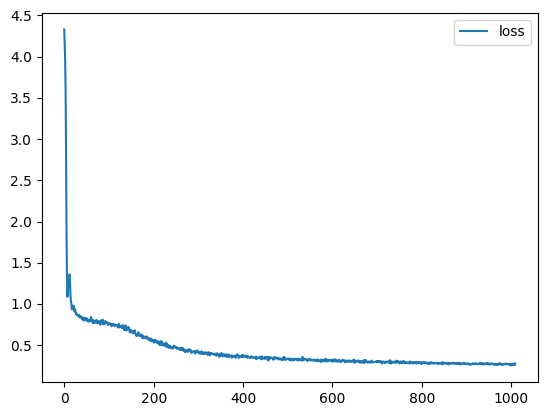

In [ ]:
model = CharLSTMLoop(num_tokens=num_tokens, embedding_size=32, rnn_num_units=256)
opt = torch.optim.Adam(model.parameters())

history = []
for i in range(1000):
    batch_ix = to_matrix(
        sample(lines, 128), pad=token_to_id[" "], max_len=MAX_LENGTH
    )
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    loss = F.nll_loss(
        logp_seq[:, :-1].contiguous().view(-1, num_tokens),
        batch_ix[:, 1:].contiguous().view(-1),
    )
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "Model didn't converge."

In [ ]:
for _ in range(10):
    print(model.generate_sample(tokens, token_to_id, max_length=MAX_LENGTH, temperature=1))

 [1W] Creature, Anvel Phanat: Tlade Leak Arpider                                                                                                                         
 [2U] Instant: Walg Zumus Hanif                                                                                                                                          
 [UB] Instant: Ulfun                                                                                                                                                     
 ['] Artifact: Fleph if thig Ancib                                                                                                                                       
 [5] Artifact: Grinf EveatTense                                                                                                                                          
 [0] Artifact: Forbited Sinid                                                                                                                         